In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy.ndimage as sd



# Step 1 and 2: Using TinySOl dataset to train a small CNN for classifying the instruments being played

In [2]:
n_mfcc=50
n_mels=30
dataset=pd.read_csv('TinySOL_metadata.csv')
dataset.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


In [3]:
# Apply data augmentation to the training data
def augment_audio(audio_data, shift_factor):
    # Apply time-domain shift to the audio signal
    augmented_data = sd.shift(audio_data, int(len(audio_data) * shift_factor))
    return augmented_data

In [4]:
#function returning a list of spectral feature matrix for each audio sample
def getSpectralFeature(paths,shift):
    listContrast=[]
    for i in paths:
        audio_data , sampling_rate = librosa.load(i)
        if (shift!=0) :
            audio_data=augment_audio(audio_data,shift)
        spectralFeature = librosa.feature.mfcc(y=audio_data,n_mfcc=n_mfcc)
        #spectralFeature = librosa.feature.melspectrogram(y=audio_data,n_mels=n_mels)
        listContrast.append(spectralFeature)    
    return listContrast
           

In [5]:
# Function to get maximum time (2nd Dimension) of Feature matrix
def maxColCount(spectralList):
    colCount=0
    count=0
    index=0
    for i in spectralList:
        if(colCount<i.shape[1]):
            colCount=i.shape[1]
            index=count
        count=count+1

    
    return [colCount,index]

In [6]:
#Function Standardising and Padding to make all input feature matrices of same size

def processedInput(dataset,shift=0):
    # Getting list of feature matrix and dimensions
    spectralList=getSpectralFeature('Audio/'+dataset.iloc[:,0],shift)
    TotalSample=len(spectralList)
    dim1=spectralList[2].shape[0]
    max_length,index=maxColCount(spectralList)
    dim2=max_length
    
    #Standardising and Padding to make all input feature matrices of same size
    newArray=np.zeros(( TotalSample,dim1,dim2,1))
    count=0
    for i in spectralList:
        newArray[count,:,:,0] = np.pad(i, ((0, 0), (0, dim2 - i.shape[1])))
        newArray[count,:,:,0]=(newArray[count,:,:,0])/(np.max(newArray[count,:,:,0])-np.min(newArray[count,:,:,0]))
        count=count+1
    
    return newArray,TotalSample,dim1,dim2

In [7]:
X,TotalSample,dim1,dim2=processedInput(dataset)
augmentedData,Ts,d1,d2=processedInput(dataset,0.2)

In [8]:
#Simple CNN model
def CNNmodel():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dim1, dim2, 1)))
    model.add(tf.keras.layers.MaxPool2D(2, 2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(14, activation='softmax'))
    return model


In [9]:
#Splitting the dataset to Train, Test and Validation

label_encoder = LabelEncoder()
y=label_encoder.fit_transform(dataset.iloc[:,3])
X_train, X_test,augmentTrainData,augmentTestData, y_train, y_test = train_test_split(X,augmentedData, y, test_size=0.2, random_state=134)
X_train, X_val,augmentTrainData,augmentValData, y_train, y_val = train_test_split(X_train,augmentTrainData, y_train, test_size=0.2, random_state=123)


In [10]:
modelTrueLabel=CNNmodel()
modelTrueLabel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
#Training the model
history_correct_labels=modelTrueLabel.fit(X_train,y_train,validation_data=(X_val,y_val),  epochs=20)
modelTrueLabel.summary()

Epoch 1/20
59/59 [==============================] - 7s 118ms/step - loss: 1.2412 - accuracy: 0.6352 - val_loss: 0.5176 - val_accuracy: 0.8476
Epoch 2/20
59/59 [==============================] - 7s 116ms/step - loss: 0.3213 - accuracy: 0.9024 - val_loss: 0.2685 - val_accuracy: 0.9120
Epoch 3/20
59/59 [==============================] - 7s 116ms/step - loss: 0.1629 - accuracy: 0.9517 - val_loss: 0.2022 - val_accuracy: 0.9356
Epoch 4/20
59/59 [==============================] - 7s 116ms/step - loss: 0.0967 - accuracy: 0.9710 - val_loss: 0.1484 - val_accuracy: 0.9442
Epoch 5/20
59/59 [==============================] - 7s 117ms/step - loss: 0.0588 - accuracy: 0.9861 - val_loss: 0.1108 - val_accuracy: 0.9678
Epoch 6/20
59/59 [==============================] - 7s 118ms/step - loss: 0.0292 - accuracy: 0.9946 - val_loss: 0.0836 - val_accuracy: 0.9785
Epoch 7/20
59/59 [==============================] - 7s 118ms/step - loss: 0.0140 - accuracy: 0.9989 - val_loss: 0.0842 - val_accuracy: 0.9721
Epoch 

In [12]:
modelTrueLabel.evaluate(X_test,y_test)

19/19 [==============================] - 1s 31ms/step - loss: 0.1198 - accuracy: 0.9657


[0.11980117857456207, 0.9656946659088135]

# Step 3: Writing a general dataset class, which returns dictionary 

In [13]:
class datasetClass:
    
    def __init__(self, pathCSV,pathAudioFolder):
        self.dataset=pd.read_csv(pathCSV)
        self.audioPath1=pathAudioFolder

    def __getitem__(self,i):
        self.audioPath=self.audioPath1+self.dataset.iloc[i,0]
        self.AudioProcessed, sr=librosa.load(self.audioPath)
        self.melspec=librosa.feature.melspectrogram(y=self.AudioProcessed,n_mels=30)
        self.mfcc=X[i][np.newaxis, :]
        data_dict = {
                'file': os.path.basename(self.audioPath),
                'audio': self.AudioProcessed.reshape((1,len(self.AudioProcessed))),  # Add batch dimension
                'mel':   self.melspec.reshape((1,self.melspec.shape[0],self.melspec.shape[1])),
                'gt':    (label_encoder.fit_transform([self.dataset.iloc[i,3]]))[0],
                'pseudo': np.argmax(modelTrueLabel.predict(self.mfcc,verbose=0),axis=1)[0]
            }
        

        return data_dict



In [14]:
# Fxn to get pseduo labels using datasetClass
def getPseudolabels(pathCSV, pathAudioFolder):
    dicti=datasetClass(pathCSV,pathAudioFolder)
    count=0
    PredictionSpectroDict=np.zeros((len(dataset.iloc[:,0])),dtype=int)
    for i in range(0,len(dataset.iloc[:,3])) :
        PredictionSpectroDict[i]=(dicti[i])['pseudo']
    
    return PredictionSpectroDict

In [15]:
# getting dictionary for a given index

dicti= datasetClass('TinySOL_metadata.csv','Audio/')
dicti[0]



{'file': 'BTb-ord-F#1-pp-N-N.wav',
 'audio': array([[ 9.0362955e-06,  1.0625219e-05, -1.9754501e-05, ...,
         -2.0267985e-06,  8.9964906e-06,  1.0077965e-05]], dtype=float32),
 'mel': array([[[1.8236044e-04, 3.0093154e-04, 6.5178273e-04, ...,
          5.0131528e-04, 1.1879140e-04, 1.5101220e-05],
         [1.4845637e-04, 9.4261901e-05, 1.3311718e-04, ...,
          9.9567049e-05, 1.9712970e-05, 2.4334026e-06],
         [2.6849503e-04, 1.0725656e-04, 2.6847738e-05, ...,
          4.6358200e-05, 1.0446354e-05, 1.7586473e-06],
         ...,
         [5.3874820e-09, 8.9381746e-09, 9.0201278e-09, ...,
          9.8180735e-09, 8.7549603e-09, 4.5747885e-09],
         [4.0898822e-09, 7.5733402e-09, 7.6328668e-09, ...,
          9.0652792e-09, 8.9257899e-09, 5.5883906e-09],
         [3.4580263e-09, 6.9276842e-09, 7.8879596e-09, ...,
          8.3824405e-09, 8.7153387e-09, 4.8276148e-09]]], dtype=float32),
 'gt': 0,
 'pseudo': 2}

In [16]:
#Fetching pseudolabels
#PseudoLabels=getPseudolabels('TinySOL_metadata.csv','Audio/')

# Step 4: Training CNN with pseudo labels

In [17]:
# Training with pseudo labels
modelPseudoLabel=CNNmodel()
modelPseudoLabel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_pseudo_labels=modelPseudoLabel.fit(X_train,np.argmax(modelTrueLabel.predict(X_train),axis=1),validation_data=(X_val,np.argmax(modelTrueLabel.predict(X_val),axis=1)),  epochs=20)
modelPseudoLabel.summary()

15/15 [==============================] - 0s 32ms/step
Epoch 1/20
59/59 [==============================] - 8s 130ms/step - loss: 1.4694 - accuracy: 0.5740 - val_loss: 0.7049 - val_accuracy: 0.8283
Epoch 2/20
59/59 [==============================] - 7s 125ms/step - loss: 0.4485 - accuracy: 0.8782 - val_loss: 0.3926 - val_accuracy: 0.8712
Epoch 3/20
59/59 [==============================] - 7s 122ms/step - loss: 0.2154 - accuracy: 0.9388 - val_loss: 0.2036 - val_accuracy: 0.9442
Epoch 4/20
59/59 [==============================] - 7s 124ms/step - loss: 0.1074 - accuracy: 0.9737 - val_loss: 0.2047 - val_accuracy: 0.9313
Epoch 5/20
59/59 [==============================] - 8s 129ms/step - loss: 0.0884 - accuracy: 0.9796 - val_loss: 0.1307 - val_accuracy: 0.9571
Epoch 6/20
59/59 [==============================] - 8s 137ms/step - loss: 0.0364 - accuracy: 0.9968 - val_loss: 0.1210 - val_accuracy: 0.9592
Epoch 7/20
59/59 [==============================] - 9s 144ms/step - loss: 0.0252 - accuracy: 0

# Step 5: Analysing results and plotting graphs for model comparison

Text(0, 0.5, 'Loss')

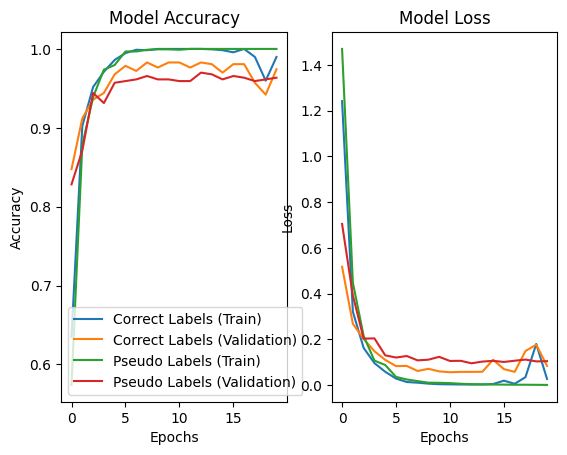

In [18]:
#Plotting the trend of accuracy and loss for the two models with number of epochs
plt.subplot(1, 2, 1)
plt.plot(history_correct_labels.history['accuracy'], label='Correct Labels (Train)')
plt.plot(history_correct_labels.history['val_accuracy'], label='Correct Labels (Validation)')
plt.plot(history_pseudo_labels.history['accuracy'], label='Pseudo Labels (Train)')
plt.plot(history_pseudo_labels.history['val_accuracy'], label='Pseudo Labels (Validation)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_correct_labels.history['loss'], label='Correct Labels (Train)')
plt.plot(history_correct_labels.history['val_loss'], label='Correct Labels (Validation)')
plt.plot(history_pseudo_labels.history['loss'], label='Pseudo Labels (Train)')
plt.plot(history_pseudo_labels.history['val_loss'], label='Pseudo Labels (Validation)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### While the accuracy and loss for both models while training are very similar, validation accuracy is slghtly higher for the model trained using the True Labels

Text(0.5, 1.0, 'Confusion Matrix (Pseudo Labels)')

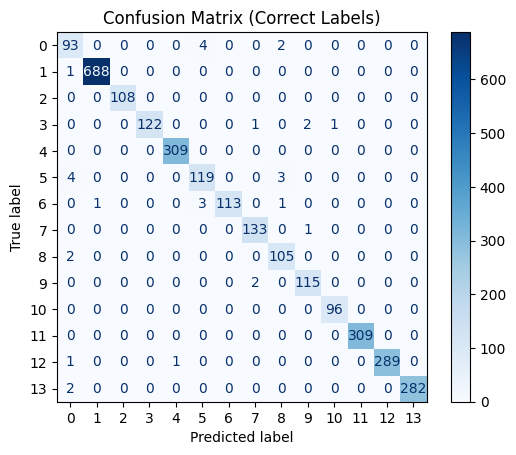

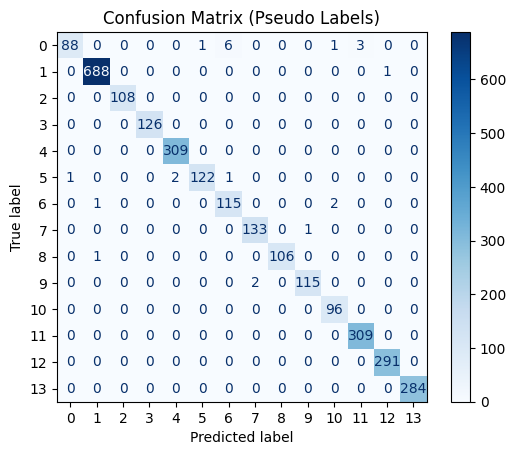

In [19]:
# Create confusion matrices

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix_correct_labels = confusion_matrix(y, np.argmax(modelTrueLabel.predict(X,verbose=0),axis=1))
conf_matrix_pseudo_labels = confusion_matrix(y, (np.argmax(modelPseudoLabel.predict(X,verbose=0),axis=1)))

labels = range(0,14)  # Assuming class labels are integers

ConfusionMatrixDisplay(conf_matrix_correct_labels, display_labels=labels).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Correct Labels)')
ConfusionMatrixDisplay(conf_matrix_pseudo_labels, display_labels=labels).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Pseudo Labels)')


### From the confusion matrix on the complete dataset we cannot infer any major difference in results of models trained using Pseudo Labels and True Labels

In [20]:
print(f'Accuracy of model trained using Pseudo Labels: \n a) On validation data: {modelPseudoLabel.evaluate(X_val,y_val,verbose=0)}\n b) On test data: {modelPseudoLabel.evaluate(X_test,y_test,verbose=0)}')
print(f'Accuracy of model trained using True Labels: \n a) On validation data: {modelTrueLabel.evaluate(X_val,y_val,verbose=0)}\n b) On test data: {modelTrueLabel.evaluate(X_test,y_test,verbose=0)}')


Accuracy of model trained using Pseudo Labels: 
 a) On validation data: [0.06210533529520035, 0.9763948321342468]
 b) On test data: [0.06376220285892487, 0.9794167876243591]
Accuracy of model trained using True Labels: 
 a) On validation data: [0.08454194664955139, 0.9742489457130432]
 b) On test data: [0.11980117857456207, 0.9656946659088135]


### On comparing the loss and accuracy on the test and validation data of the two models we can clearly see that the model trained on true labels performs better than the model trained on pseudo labels

# Step 6: Improving the performance of the CNN in Step-4

In [21]:

modelPseudoImproved=CNNmodel()
modelPseudoImproved.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#Randomly replacing half of the actual train data with augmented train data
randomIndex=np.random.choice(range(0,augmentTrainData.shape[0]),int(augmentTrainData.shape[0]*0.5))
for i in range(0,augmentTrainData.shape[0]):
    augmentTrainData[i]=X_train[i]
randomIndex=np.random.choice(range(0,augmentValData.shape[0]),int(augmentValData.shape[0]*0.5))
for i in range(0,augmentValData.shape[0]):
    augmentValData[i]=X_val[i]


history_pseudo_improved=modelPseudoImproved.fit(augmentTrainData,np.argmax(modelTrueLabel.predict(X_train),axis=1),validation_data=(augmentValData,np.argmax(modelTrueLabel.predict(X_val),axis=1)),  epochs=20)
modelPseudoImproved.summary()


15/15 [==============================] - 0s 30ms/step
Epoch 1/20
59/59 [==============================] - 7s 121ms/step - loss: 1.4553 - accuracy: 0.5778 - val_loss: 0.7674 - val_accuracy: 0.7747
Epoch 2/20
59/59 [==============================] - 7s 123ms/step - loss: 0.4337 - accuracy: 0.8793 - val_loss: 0.3743 - val_accuracy: 0.8863
Epoch 3/20
59/59 [==============================] - 7s 120ms/step - loss: 0.1799 - accuracy: 0.9517 - val_loss: 0.2371 - val_accuracy: 0.9313
Epoch 4/20
59/59 [==============================] - 7s 120ms/step - loss: 0.0872 - accuracy: 0.9812 - val_loss: 0.2037 - val_accuracy: 0.9313
Epoch 5/20
59/59 [==============================] - 7s 121ms/step - loss: 0.0904 - accuracy: 0.9726 - val_loss: 0.1708 - val_accuracy: 0.9485
Epoch 6/20
59/59 [==============================] - 7s 119ms/step - loss: 0.0482 - accuracy: 0.9920 - val_loss: 0.1421 - val_accuracy: 0.9571
Epoch 7/20
59/59 [==============================] - 7s 120ms/step - loss: 0.0224 - accuracy: 0

In [22]:
print(f'Accuracy of model trained using Pseudo Labels: \n a) On validation data: {modelPseudoLabel.evaluate(X_val,y_val,verbose=0)}\n b) On test data: {modelPseudoLabel.evaluate(X_test,y_test,verbose=0)}\n')
print(f'Accuracy of model trained using True Labels: \n a) On validation data: {modelTrueLabel.evaluate(X_val,y_val,verbose=0)}\n b) On test data: {modelTrueLabel.evaluate(X_test,y_test,verbose=0)}\n')
print(f'Accuracy of improved model trained using Pseudo Labels: \n a) On validation data: {modelPseudoImproved.evaluate(X_val,y_val,verbose=0)}\n b) On test data: {modelPseudoImproved.evaluate(X_test,y_test,verbose=0)}')




Accuracy of model trained using Pseudo Labels: 
 a) On validation data: [0.06210533529520035, 0.9763948321342468]
 b) On test data: [0.06376220285892487, 0.9794167876243591]

Accuracy of model trained using True Labels: 
 a) On validation data: [0.08454194664955139, 0.9742489457130432]
 b) On test data: [0.11980117857456207, 0.9656946659088135]

Accuracy of improved model trained using Pseudo Labels: 
 a) On validation data: [0.046492937952280045, 0.9892703890800476]
 b) On test data: [0.05389754846692085, 0.9725557565689087]


### As can be clearly seen, on doing data augmentation, the accuracy of the model trained with pseduo labels improved.
### Some other ways of improving accuracy could be doing batch normalisation,adding dropout layers, changing the n_mfcc, hop length of the feature extracted, regularisation, changing the learning rate, etc.